# Training Land Cover Classifiers using Image Histograms
In this notebook, we will train two classification algorithms to predict the land cover type of an area for which histograms of several imagery and other spatial layers have been prepared.

We've developed training and validation subsets comprising samples from areas where the landscape has been delineated into forest (and non-forest) management units by foresters employed by state and federal agencies in Oregon and Washington. 

Each agency and forest adopted different land cover classification schemes. We consolidated the land cover typology used by each agency and forester into the following five classes:

* 1 = Water
* 2 = Forest
* 3 = Field
* 4 = Barren/Non-vegetated
* 5 = Developed

Each observation in the training and validation datasets represents a stand that was hand-delineated (typically using high-resolution aerial imagery) by a professional forester. Each stand is summarized using a histogram of values (each with 16 bins) depicting the distribution of pixel values within that stand from several input layers.

There are 15 image channels summarized for each superpixel:
* NAIP aerial imagery (4-channel: R,G,B,NIR)
* LANDSAT leaf-on imagery (4-channel: R,G,B,NIR)
* 4 terrain channels (elevation, slope, and topographic position index at 300m and 2000m)
* 3 channels depicting the distance from hydrological features, roads, and buildings, clipped to the range of 0-100 meters. 

For each tile (approximately 5000 x 7000-meter footprint), we randomly selected 10 stands to include in the training and validation subsets. 80% of the tiles available from each agency were included in the training set, and 20% were used for validation. This split helps to ensure that the different forest types related to the agencies are well-reflected in both training and validation datasets.

Once we have trained a decent classification model using these data, we will utilize it to (re-)assign land cover types to each area delineated by foresters across Oregon and Washington. This approach helps to ensure that land cover classifications are made consistently within and between datasets created by different foresters, and to update cover types in the original datasets that appear to be out-of-date (e.g., where cover typing was done before the year in which the agency released the data and does not reflect harvest or other disturbance that may be apparent from the imagery).

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import glob
import numpy as np
from collections import Counter
import pandas as pd
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, log_loss
from imblearn.metrics import classification_report_imbalanced

from matplotlib import pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [3]:
TRAIN_CSV = '/content/drive/Shareddrives/stand_mapping/data/interim/land_cover_modeling/train_histograms.csv'
TEST_CSV = '/content/drive/Shareddrives/stand_mapping/data/interim/land_cover_modeling/validation_histograms.csv'

train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)

In [4]:
x_cols = [col for col in train.columns if 'hist' in col]
print(x_cols)

['NAIP-R_hist-0', 'NAIP-R_hist-1', 'NAIP-R_hist-2', 'NAIP-R_hist-3', 'NAIP-R_hist-4', 'NAIP-R_hist-5', 'NAIP-R_hist-6', 'NAIP-R_hist-7', 'NAIP-R_hist-8', 'NAIP-R_hist-9', 'NAIP-R_hist-10', 'NAIP-R_hist-11', 'NAIP-R_hist-12', 'NAIP-R_hist-13', 'NAIP-R_hist-14', 'NAIP-R_hist-15', 'NAIP-G_hist-0', 'NAIP-G_hist-1', 'NAIP-G_hist-2', 'NAIP-G_hist-3', 'NAIP-G_hist-4', 'NAIP-G_hist-5', 'NAIP-G_hist-6', 'NAIP-G_hist-7', 'NAIP-G_hist-8', 'NAIP-G_hist-9', 'NAIP-G_hist-10', 'NAIP-G_hist-11', 'NAIP-G_hist-12', 'NAIP-G_hist-13', 'NAIP-G_hist-14', 'NAIP-G_hist-15', 'NAIP-B_hist-0', 'NAIP-B_hist-1', 'NAIP-B_hist-2', 'NAIP-B_hist-3', 'NAIP-B_hist-4', 'NAIP-B_hist-5', 'NAIP-B_hist-6', 'NAIP-B_hist-7', 'NAIP-B_hist-8', 'NAIP-B_hist-9', 'NAIP-B_hist-10', 'NAIP-B_hist-11', 'NAIP-B_hist-12', 'NAIP-B_hist-13', 'NAIP-B_hist-14', 'NAIP-B_hist-15', 'NAIP-NIR_hist-0', 'NAIP-NIR_hist-1', 'NAIP-NIR_hist-2', 'NAIP-NIR_hist-3', 'NAIP-NIR_hist-4', 'NAIP-NIR_hist-5', 'NAIP-NIR_hist-6', 'NAIP-NIR_hist-7', 'NAIP-NIR_his

In [5]:
X_train, X_test = train[x_cols], test[x_cols]
y_train, y_test = train['COVER_TYPE'], test['COVER_TYPE']

In [6]:
X_train.head()

,NAIP-R_hist-0,NAIP-R_hist-1,NAIP-R_hist-2,NAIP-R_hist-3,NAIP-R_hist-4,NAIP-R_hist-5,NAIP-R_hist-6,NAIP-R_hist-7,NAIP-R_hist-8,NAIP-R_hist-9,NAIP-R_hist-10,NAIP-R_hist-11,NAIP-R_hist-12,NAIP-R_hist-13,NAIP-R_hist-14,NAIP-R_hist-15,NAIP-G_hist-0,NAIP-G_hist-1,NAIP-G_hist-2,NAIP-G_hist-3,NAIP-G_hist-4,NAIP-G_hist-5,NAIP-G_hist-6,NAIP-G_hist-7,NAIP-G_hist-8,NAIP-G_hist-9,NAIP-G_hist-10,NAIP-G_hist-11,NAIP-G_hist-12,NAIP-G_hist-13,NAIP-G_hist-14,NAIP-G_hist-15,NAIP-B_hist-0,NAIP-B_hist-1,NAIP-B_hist-2,NAIP-B_hist-3,NAIP-B_hist-4,NAIP-B_hist-5,NAIP-B_hist-6,NAIP-B_hist-7,...,HYDRO_hist-8,HYDRO_hist-9,HYDRO_hist-10,HYDRO_hist-11,HYDRO_hist-12,HYDRO_hist-13,HYDRO_hist-14,HYDRO_hist-15,ROADS_hist-0,ROADS_hist-1,ROADS_hist-2,ROADS_hist-3,ROADS_hist-4,ROADS_hist-5,ROADS_hist-6,ROADS_hist-7,ROADS_hist-8,ROADS_hist-9,ROADS_hist-10,ROADS_hist-11,ROADS_hist-12,ROADS_hist-13,ROADS_hist-14,ROADS_hist-15,BLDGS_hist-0,BLDGS_hist-1,BLDGS_hist-2,BLDGS_hist-3,BLDGS_hist-4,BLDGS_hist-5,BLDGS_hist-6,BLDGS_hist-7,BLDGS_hist-8,BLDGS_hist-9,BLDGS_hist-10,BLDGS_hist-11,BLDGS_hist-12,BLDGS_hist-13,BLDGS_hist-14,BLDGS_hist-15
0,0.000000,0.003723,0.011968,0.017021,0.023936,0.030585,0.040691,0.044415,0.065426,0.087766,0.104255,0.136170,0.080851,0.084043,0.269149,0.000000,0.000532,0.010372,0.016223,0.025266,0.031915,0.038298,0.066755,0.064628,0.089894,0.094415,0.085106,0.069947,0.056383,0.086702,0.263298,0.000266,0.006117,0.021543,0.038298,0.043351,0.057181,0.067021,0.081383,0.087234,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.000000,0.000089,0.001160,0.007675,0.024632,0.051495,0.076751,0.108344,0.137439,0.187059,0.212137,0.142526,0.046051,0.004373,0.000268,0.000000,0.000000,0.000714,0.007229,0.021062,0.043641,0.075591,0.096921,0.118340,0.148773,0.181883,0.184917,0.093530,0.025346,0.001785,0.000268,0.000000,0.000625,0.005087,0.022044,0.043909,0.075591,0.109326,0.122445,0.136278,...,0.113342,0.047747,0.022490,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.000000,0.012881,0.159150,0.163889,0.116309,0.099421,0.092583,0.090007,0.093410,0.081420,0.060810,0.024426,0.004294,0.000509,0.000700,0.000191,0.000572,0.058838,0.173589,0.125183,0.098149,0.086922,0.082024,0.083233,0.086159,0.084028,0.074645,0.042364,0.003180,0.000445,0.000668,0.000000,0.003339,0.068762,0.157401,0.135647,0.103333,0.085300,0.083741,0.090389,...,0.031391,0.029546,0.031423,0.035494,0.047452,0.043509,0.043191,0.647287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,0.000522,0.015152,0.043191,0.043539,0.028910,0.039185,0.037792,0.062348,0.088471,0.168234,0.261233,0.182689,0.026123,0.002612,0.000000,0.000000,0.001916,0.020724,0.062870,0.046325,0.041101,0.043016,0.059039,0.073494,0.114768,0.193835,0.219958,0.104493,0.015152,0.003309,0.000000,0.000000,0.006444,0.034657,0.054162,0.073145,0.055033,0.064786,0.082898,...,0.040578,0.000697,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.000124,0.015078,0.117167,0.106167,0.089482,0.089482,0.081449,0.073662,0.059449,0.060438,0.068471,0.128044,0.099493,0.003090,0.007168,0.001236,0.000865,0.038191,0.133358,0.098505,0.080707,0.078606,0.073044,0.072550,0.073662,0.078729,0.137189,0.117291,0.006798,0.002595,0.006674,0.001236,0.004326,0.062662,0.120875,0.123347,0.080213,0.073168,0.087628,0.097269,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
Counter(y_train.values), Counter(y_test.values)

(Counter({1: 211, 2: 8886, 3: 1128, 4: 644, 5: 34}),
 Counter({1: 42, 2: 2356, 3: 231, 4: 129, 5: 9}))

## Benchmarking
We score our models using Multinomial Logistic Loss (also known as Cross Entropy Loss). This scoring function quantifies how well the predicted probabilities of each class the classifier estimates for each sample corresponds to the actual target value. 

To offer a frame of reference for whether our classification models are doing well or not, we can see what a "dumb" model that simply predicted probabilities for each class that reflect the abundance of each class in the training and/or validation sets.

In [8]:
train_counts = Counter(y_train.values)
test_counts = Counter(y_test.values)
train_probs = [train_counts[x+1]/len(y_train) for x in range(5)]
test_probs = [test_counts[x+1]/len(y_test) for x in range(5)]
print([f'{x:.1%}' for x in train_probs])
print([f'{x:.1%}' for x in test_probs])

['1.9%', '81.5%', '10.3%', '5.9%', '0.3%']
['1.5%', '85.1%', '8.3%', '4.7%', '0.3%']


For example, if a "dumb" model that had seen the training dataset would always predict the following, regardless of the input data:

| class | water | forest | field | barren | developed |
|:------|:-----:|:------:|:-----:|:------:|:---------:|
|probability| 1.9% | 81.5% | 10.3% | 5.9% | 0.3% |
  
  
If the "dumb" model had seen the validation dataset, it would always predict the following, regardless of the input data:

| class | water | forest | field | barren | developed |
|:------|:-----:|:------:|:-----:|:------:|:---------:|
|probability| 1.5% | 85.1% | 8.3% | 4.7% | 0.3% |

In [9]:
# baseline probabilities if you picked probabilities based on proportion of classes
dumb_train_val = log_loss(y_test, [train_probs]*len(y_test))
dumb_test_val = log_loss(y_test, [test_probs]*len(y_test))

print('Multinomial Logistic Loss if "dumb" model had seen...')
print(f'Training dataset: \t {dumb_train_val:.03f}')
print(f'Validation dataset: \t {dumb_test_val:.03f}')

Multinomial Logistic Loss if "dumb" model had seen...
Training dataset: 	 0.574
Validation dataset: 	 0.569


## Models
We try two common models for classification problems:
* RandomForestClassifier
* LogisticRegression

As we were developing this notebook, we did some experimentation (not retained here) to see what reasonable hyperparameter settings. The settings used in the construction of each model below were initially chosen as sensible defaults and were still the best options after a hyperparameter tuning and cross-validation. To minimize clutter, the tuning code that did not produce better model fits than these default values has been omitted.

## Fitting and Inspecting the Random Forest Model

In [10]:
rf = RandomForestClassifier(
    n_estimators=250, 
    max_depth=40, 
    class_weight='balanced', 
    n_jobs=-1
    )

In [11]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

We can see that the RandomForestClassifier outperforms the "dumb" models.

In [12]:
log_loss(y_test, rf.predict_proba(X_test), labels=[1,2,3,4,5])

0.39404585837969064

We also see, however, that it never predicts a "developed" class as the most likely category for any of the validation observations. 

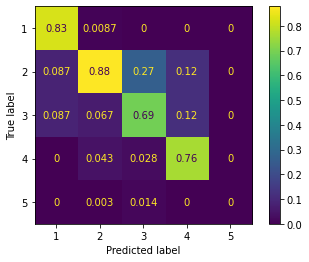

In [13]:
plot_confusion_matrix(rf, X_test, y_test, labels=[1,2,3,4,5], normalize='pred');

We can inspect some other useful statistics like precision, recall, specificity, F1-score, geometric mean, index-balanced accuracy, and support (number of samples) using `classification_report_imbalanced` from the `imblearn` package.

In [14]:
print(classification_report_imbalanced(y_test, 
                                       rf.predict(X_test), 
                                       labels=[1,2,3,4,5], 
                                       target_names=['water', 'forest', 'field', 
                                                     'barren', 'developed']
                                       ))

                   pre       rec       spe        f1       geo       iba       sup

      water       0.83      0.45      1.00      0.58      0.67      0.43        42
     forest       0.88      0.99      0.21      0.93      0.46      0.23      2356
      field       0.69      0.21      0.99      0.32      0.46      0.19       231
     barren       0.76      0.10      1.00      0.18      0.32      0.09       129
  developed       0.00      0.00      1.00      0.00      0.00      0.00         9

avg / total       0.85      0.87      0.33      0.84      0.46      0.22      2767



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Save the Random Forest model to disk

In [15]:
OUT_RF = '/content/drive/Shareddrives/stand_mapping/models/RandomForestClassifier_LandCoverClassifier_Histograms.joblib'
joblib.dump(rf, OUT_RF)

['/content/drive/Shareddrives/stand_mapping/models/RandomForestClassifier_LandCoverClassifier_Histograms.joblib']

## Fitting and Inspecting the Logistic Regression Model

In [16]:
log = LogisticRegression(max_iter=1e3, solver='lbfgs')

In [17]:
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000.0,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We can see that the LogisticRegression model outperforms the "dumb" models.

In [18]:
log_loss(y_test, log.predict_proba(X_test), labels=[1,2,3,4,5])

0.3931264280663945

Similar to the RandomForestClassifier, the LogisticRegression model never predicts a "developed" class as the most likely category for any of the validation observations. 


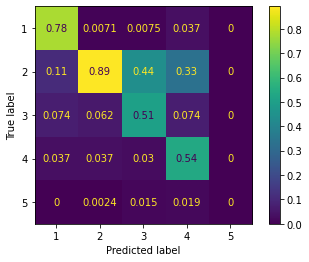

In [19]:
plot_confusion_matrix(log, X_test, y_test, labels=[1,2,3,4,5], normalize='pred');

In [20]:
print(classification_report_imbalanced(y_test, 
                                       log.predict(X_test), 
                                       labels=[1,2,3,4,5], 
                                       target_names=['water', 'forest', 'field', 
                                                     'barren', 'developed']
                                       ))

                   pre       rec       spe        f1       geo       iba       sup

      water       0.78      0.50      1.00      0.61      0.71      0.47        42
     forest       0.89      0.97      0.33      0.93      0.56      0.34      2356
      field       0.51      0.29      0.97      0.37      0.54      0.27       231
     barren       0.54      0.22      0.99      0.32      0.47      0.21       129
  developed       0.00      0.00      1.00      0.00      0.00      0.00         9

avg / total       0.84      0.87      0.43      0.84      0.56      0.33      2767



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Save the Logistic Regression model to disk

In [21]:
OUT_LOG = '/content/drive/Shareddrives/stand_mapping/models/LogisticRegression_LandCoverClassifier_Histograms.joblib'
joblib.dump(log, OUT_LOG)

['/content/drive/Shareddrives/stand_mapping/models/LogisticRegression_LandCoverClassifier_Histograms.joblib']